In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

import emcee

In [10]:
# Define the data and constants
N = 10                              # number of experiments
sig2 = 1                            # population variance
n_i = np.arange(10, 110, 10)        # number of data in each experiment
x_i = np.array([0.65, 1.30, 1.15, 1.05, 0.53, 0.78, 1.36, 0.94, 1.09, 0.93])    # mean values of the experiments
sigma_i2 = sig2 / n_i

# Define hyperposterior function (non-informative hyperprior)
def log_hyperposterior(params: np.array, x_i: np.array, sigma_i2: np.array):

    # Fetch model parameters
    phi_1, phi_2 = params

    # Calculate tau
    tau_inv = np.sum(1 / (sigma_i2 + phi_2))
    tau = 1 / tau_inv

    # Calculate nu
    nu = tau * np.sum(x_i / (sigma_i2 + phi_2))

    # Calculate first term
    first_term = (phi_1 - nu)**2 / tau

    # Calculate summation term
    A = np.log(sigma_i2 + phi_2)
    B = (x_i - nu)**2 / (sigma_i2 + phi_2)
    sum_term = np.sum(A + B)

    return -0.5 * (first_term + sum_term)

In [11]:
# Define boundary for phi's
phi_1_boundary = (0.5, 1.5)
phi_2_boundary = (0.001, 0.2)
param_boundaries = [phi_1_boundary, phi_2_boundary]

# Create contour plot for phi_1 and phi_2
phi_1_trials = np.linspace(phi_1_boundary[0], phi_1_boundary[1], 100)
phi_2_trials = np.linspace(phi_2_boundary[0], phi_2_boundary[1], 100)

# Calculate the level at every phi combination
level_val = []
for phi_1 in phi_1_trials:
    for phi_2 in phi_2_trials:
        level_val.append([phi_1, phi_2, (log_hyperposterior(np.array([phi_1, phi_2]), x_i, sigma_i2))])

level_val = np.array(level_val)

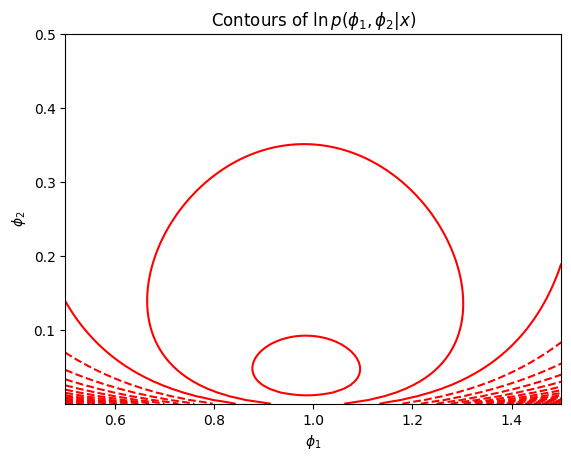

In [12]:
# Grid of phi1 and phi2 values
phi_1_values = np.linspace(0.5, 1.5, 100) 
phi_2_values = np.linspace(0.001, 0.5, 100)
phi_1_grid, phi_2_grid = np.meshgrid(phi_1_values, phi_2_values)
log_density_grid = np.zeros_like(phi_1_grid)
for i in range(phi_1_grid.shape[0]):
    for j in range(phi_1_grid.shape[1]):
        log_density_grid[i, j] = log_hyperposterior((phi_1_grid[i, j], phi_2_grid[i, j]), x_i, sigma_i2)

# Plot contours
plt.contour(phi_1_grid, phi_2_grid, (log_density_grid), levels=20, colors='red')
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.title(r'Contours of $\ln p(\phi_1, \phi_2|x)$')
plt.show()

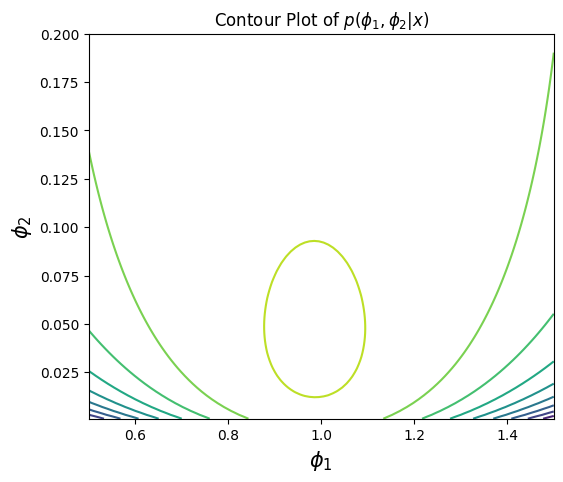

In [13]:
# Extract x, y, z
x, y, z = level_val[:, 0], level_val[:, 1], level_val[:, 2]

# Create a grid for interpolation
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(xi, yi)

# Interpolate z values on the grid
Z = griddata((x, y), z, (X, Y), method='cubic')

# Plot contour
plt.figure(figsize=(6, 5))
contour = plt.contour(X, Y, Z, levels=10, cmap='viridis')  # Filled contour
# plt.colorbar(contour, label='Z value')

# Plot original data points
# plt.scatter(x, y, color='red', marker='o', label='Data points')
plt.xlabel(r"$\phi_1$", fontsize=15)
plt.ylabel(r"$\phi_2$", fontsize=15)
# plt.legend()
plt.title(r"Contour Plot of ${p(\phi_1, \phi_2 | x)}$")
plt.show()

# Use `emcee`

In [ ]:
# The log-prior function for the FP parameters
def log_prior(theta):
    phi_1, phi_2 = theta
    phi_1_bound, phi_2_bound = param_boundaries
    if phi_1_bound[0] < phi_1 < phi_1_bound[1] and phi_2_bound[0] < phi_2 < phi_2_bound[1]:
        return 0.0
    else:
        return -np.inf

# Calculate log-posterior distribution
def log_probability(theta, x_i, sigma_i2, param_boundaries):
    lp = log_prior(theta, param_boundaries)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp - log_hyperposterior(theta, x_i, sigma_i2)

# Initial guesses
best_params = np.array([1.0, 0.1])

# Specify the initial guess, the number of walkers, and dimensions
pos = best_params + 1e-4 * np.random.randn(4, 2)
nwalkers, ndim = pos.shape

# Run the MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_i, sigma_i2, param_boundaries)
)
sampler.run_mcmc(pos, 5000, progress=True, skip_initial_state_check=True)

# Flatten the chain and save as numpy array
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Get the mean values of the marginalized distribution
x_ = flat_samples.T
FP_params_mean = np.mean(x_, axis=1)

100%|██████████| 5000/5000 [00:00<00:00, 6178.84it/s]


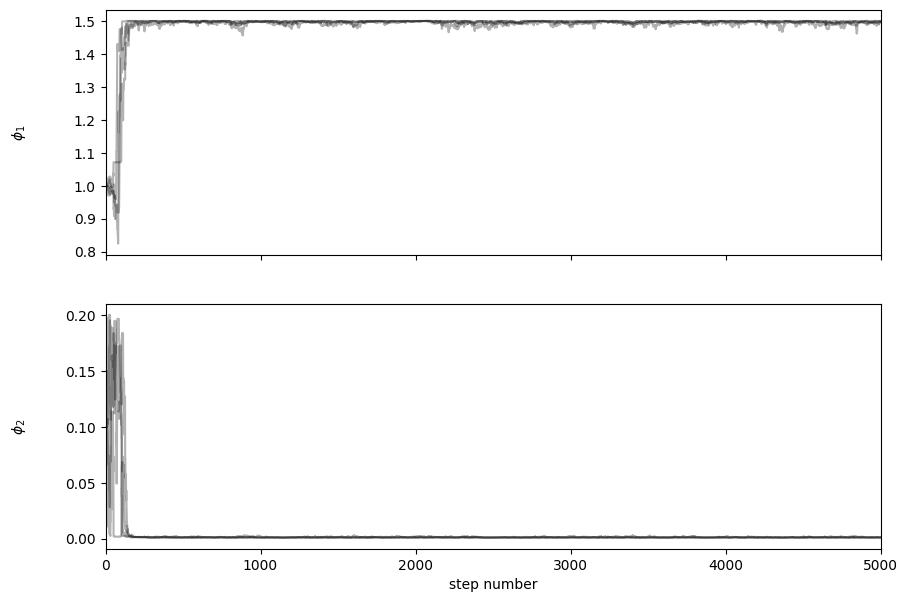

In [96]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\phi_1$", r"$\phi_2$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [14]:
# Define boundary for phi's
phi_1_boundary = (0.5, 1.5)
phi_2_boundary = (0.001, 0.2)

# The log-prior function for the FP parameters
def log_prior(theta):
    phi_1, phi_2 = theta
    if 0.6 < phi_1 < 1.4 and 0.001 < phi_2 < 0.2:
        return 0.0
    else:
        return -np.inf

# Calculate log-posterior distribution
def log_probability(theta, x_i, sigma_i2):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp - log_hyperposterior(theta, x_i, sigma_i2)

# Initial guesses
best_params = np.array([1.0, 0.1])

# Specify the initial guess, the number of walkers, and dimensions
pos = best_params + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

# Run the MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_i, sigma_i2)
)
sampler.run_mcmc(pos, 5000, progress=True, skip_initial_state_check=True)

# Flatten the chain and save as numpy array
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

# Get the mean values of the marginalized distribution
x_ = flat_samples.T
FP_params_mean = np.mean(x_, axis=1)

100%|██████████| 5000/5000 [00:01<00:00, 2767.71it/s]


Text(0.5, 0, 'step number')

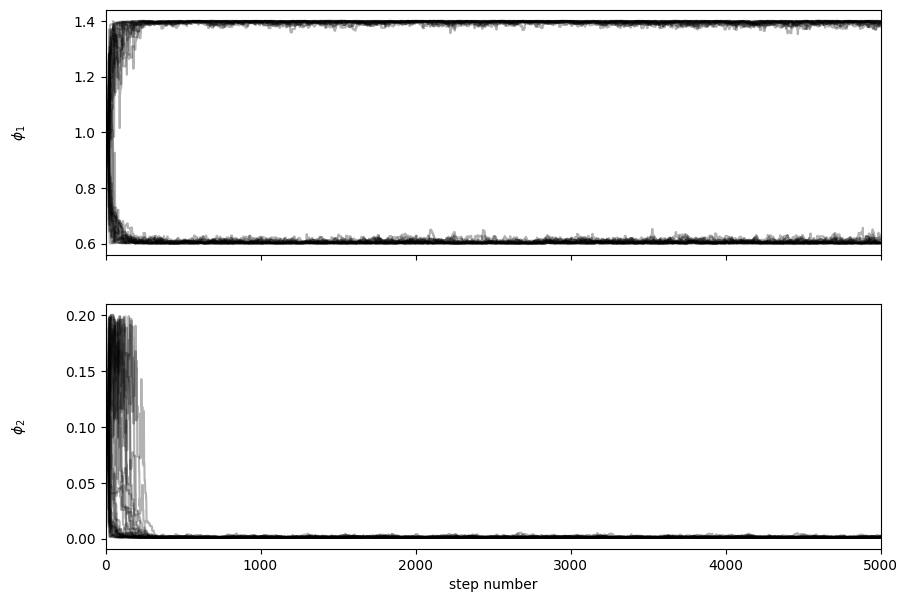

In [15]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\phi_1$", r"$\phi_2$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


# Implement Custom Metropolis-Hastings algo

In [ ]:
import numpy as np

def mcmc_updater(curr_state, curr_likeli, 
      likelihood, proposal_distribution):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposal) distribution, `mcmc_updater` generates 
      a new proposal, evaluate its likelihood, compares that to the current 
      likelihood with a uniformly samples threshold, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likeli (float): the current likelihood estimate
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = proposal_distribution(curr_state)

    # Calculate the acceptance criterion
    prop_likeli = likelihood(proposal_state)
    accept_crit = prop_likeli / curr_likeli

    # Generate a random number between 0 and 1
    accept_threshold = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if accept_crit > accept_threshold:
        return proposal_state, prop_likeli

    # Else
    return curr_state, curr_likeli


def metropolis_hastings(
        likelihood, proposal_distribution, initial_state, 
        num_samples, stepsize=0.5, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(
            curr_state=curr_state,
            curr_likeli=curr_likeli,
            likelihood=likelihood,
            proposal_distribution=proposal_distribution
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

    return samples